# 3DXRD indexing notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# desination of H5 files
# replace below with e.g.:
# dset_path = '/data/visitor/expt1234/20240101/PROCESSED_DATA/sample/dataset/sample_dataset.h5'

dset_path = ''

phase_str = 'Fe'

# path to parameters .json/.par
parfile = ''

# peak filtration options
cf_strong_frac = 0.9837
cf_strong_dsmax = 1.01
cf_strong_dstol = 0.01

# indexing options
# we have to choose which rings we want to generate orientations on
# generally we want two or three low-multiplicity rings that are isolated from other phases
# take a look at the ring assignment output from a few cells above, and choose two or three
rings_for_gen = [0, 1]

# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 1, 2, 3]

# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.75]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

# makemap parameters
makemap_hkl_tol_seq = [0.05, 0.025, 0.01]
symmetry = "cubic"

absolute_minpks = 120

dset_prefix = 'ff'

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
phase_str = "Fe"
parfile = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/pars_tdxrd.json"
cf_strong_frac = 0.9837
cf_strong_dsmax = 1.01
cf_strong_dstol = 0.01
rings_for_gen = [0, 1]
rings_for_scoring = [0, 1, 2, 3]
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04]
fracs = [0.9, 9.75]
max_grains = 1000
makemap_hkl_tol_seq = [0.05, 0.025, 0.01]
symmetry = "cubic"
absolute_minpks = 120
dset_prefix = "ff"
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/default/FeAu_0p5_tR/FeAu_0p5_tR_ff1/FeAu_0p5_tR_ff1_dataset.h5"


In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import dataset
from ImageD11.peakselect import select_ring_peaks_by_intensity
from ImageD11.nbGui import nb_utils as utils

%matplotlib widget

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/default"
sample = "FeAu_0p5_tR"
dset = "ff1"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1


## Parameters
Specify the path to your parameter file

In [6]:
ds.parfile = parfile
ds.save()

## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229}

In [8]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks

In [9]:
cf_3d = ds.get_cf_3d_from_disk()
ds.update_colfile_pars(cf_3d, phase_name=phase_str) 
cf_3d_path = 'cf_3d.flt'
cf_3d.writefile(cf_3d_path)

Reading your columnfile in hdf format


# Visualise data
### $d^{*}$ vs $\eta$

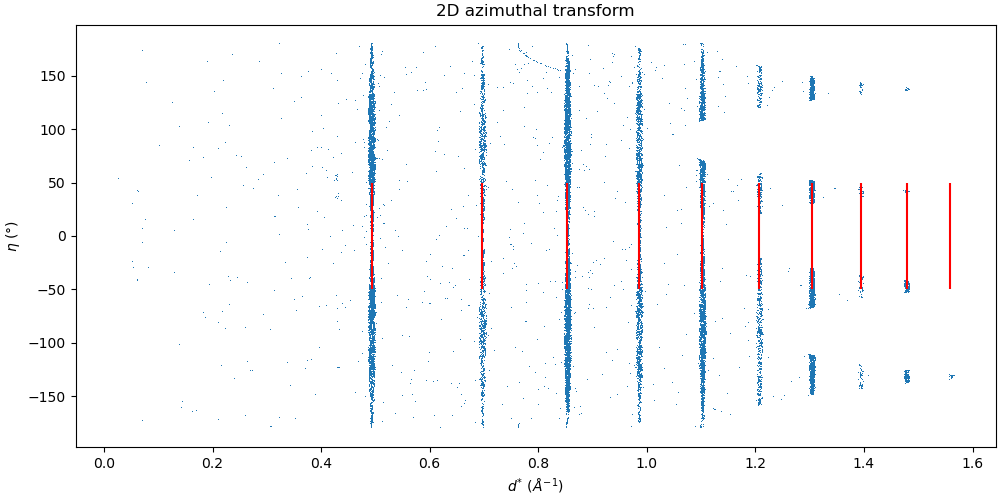

In [10]:
skip = 1  # we can skip peaks to speed up plotting if needed
ucell.makerings(cf_3d.ds.max())
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(cf_3d.ds[::skip], cf_3d.eta[::skip], ',')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
plt.show()

# Filtration
Here we are filtering our peaks (`cf_3d`) to select only the strongest ones for indexing purposes only!  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`dsmax`: The maximum allowed peak $d^{*}$ value. Used to limit the number of rings given to the indexer - 6-8 rings max are normally sufficient.   
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

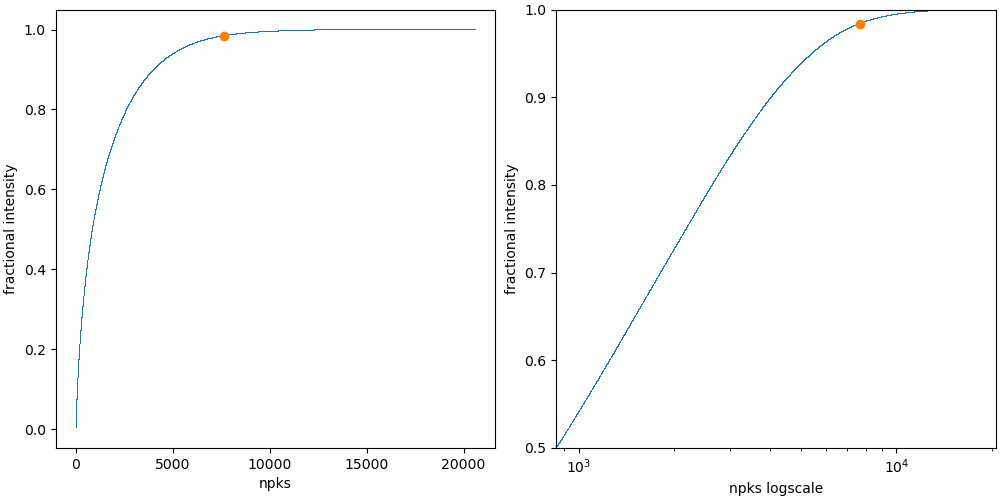

Filtered 7662 peaks from 31682


In [11]:
cf_strong = select_ring_peaks_by_intensity(cf_3d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)
cf_strong_path = 'cf_strong.flt'
cf_strong.writefile(cf_strong_path)

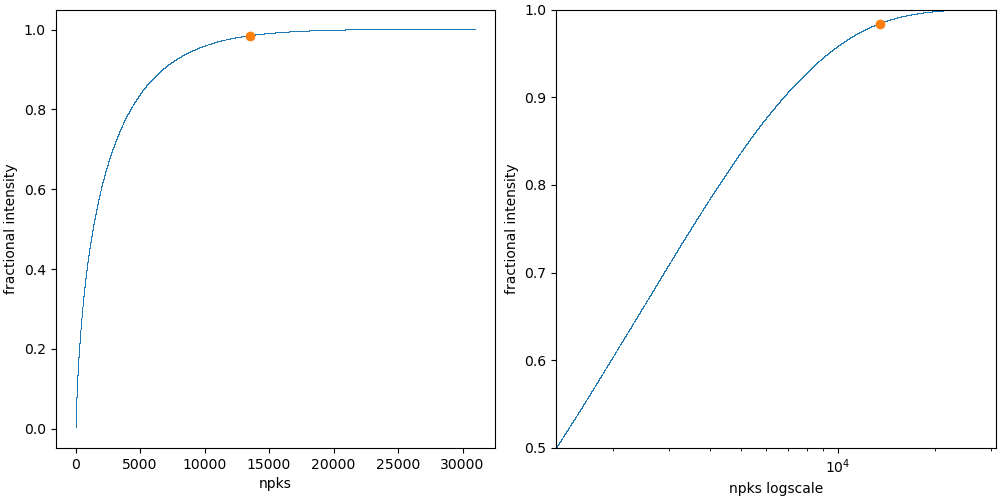

Filtered 13540 peaks from 31682


In [12]:
# we will also export some additional strong peaks across all rings
# this will be useful for grain refinement later (using makemap)
cf_strong_allrings = select_ring_peaks_by_intensity(cf_3d, frac=cf_strong_frac, dsmax=cf_3d.ds.max(), dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)
cf_strong_allrings_path = 'cf_strong_allrings.flt'
cf_strong_allrings.writefile(cf_strong_allrings_path)

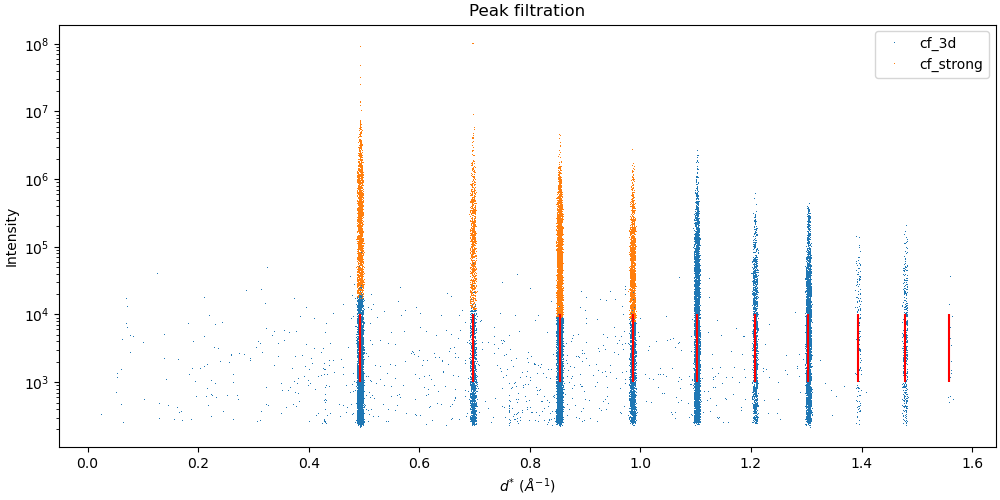

In [13]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.sum_intensity[::skip],',', label='cf_3d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment

In [14]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, ucell)
indexer.ds_tol = cf_strong_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.09866116  0.21772692 -0.81879515]
 [-0.03152412  0.04888338 -0.48747349]
 [-0.09867997  0.72385197 -0.43635119]
 ...
 [-0.05254491 -0.42837134  0.23866334]
 [-0.09029043 -0.67091598  0.14185135]
 [-0.11627422  0.95488202 -0.23424652]] (7662, 3) float64
info: Assign to rings, maximum d-spacing considered: 0.991802
info: Ring assignment array shape (7662,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 3   (  0, -2, -2)   12   1492       0     1492    61     24  16.13
info: Ring 2   ( -2, -1, -1)   24   3280       0     3280    68     48  13.95
info: Ring 1   (  0, -2,  0)    6    898       0      898    74     12  11.38
info: Ring 0   ( -1,  0, -1)   12   1992       0     1992    82     24  8.04
info: 
min_pks:  - Current  -->  10
info:           - Expected --> 108

info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (7662, 3)
Indexing 7662 peaks


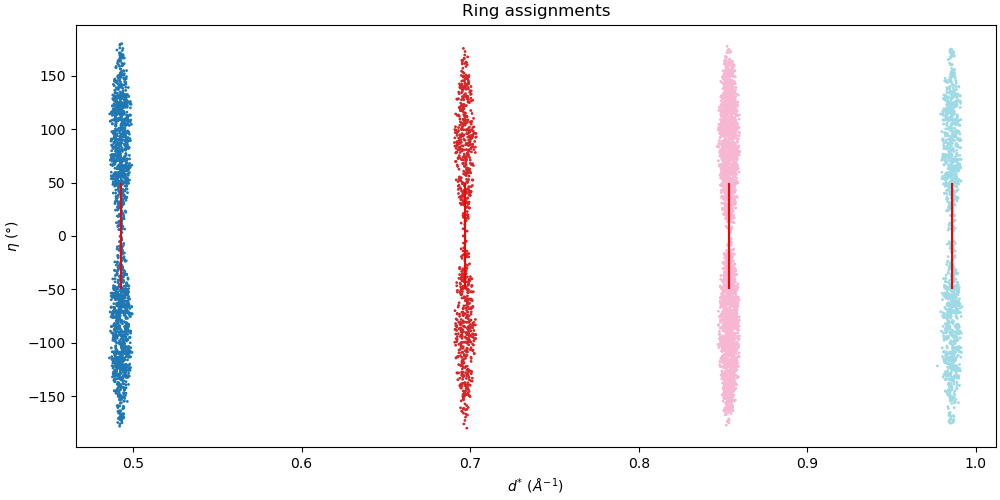

In [15]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(ucell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
plt.show()

In [16]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=ucell,
                                 dstol=cf_strong_dstol,
                                 forgen=rings_for_gen,
                                 foridx=rings_for_scoring,
                                 hkl_tols=hkl_tols_seq,
                                 fracs=fracs,
                                 cosine_tol=cosine_tol,
                                 max_grains=max_grains,
)
for ginc, g in enumerate(grains):
    g.gid = ginc
    g.translation = np.array([0., 0., 0.])
print(f'Found {len(grains)} grains!')

108 peaks expected
Trying these rings (counts, multiplicity, ring number): [(898, 6, 1), (1992, 12, 0)]


0.9 0.01 16
0.9 0.02 52
0.9 0.03 54


0.9 0.04 55
9.75 0.01 55
9.75 0.02 55


9.75 0.03 55
9.75 0.04 55
Found 55 grains!


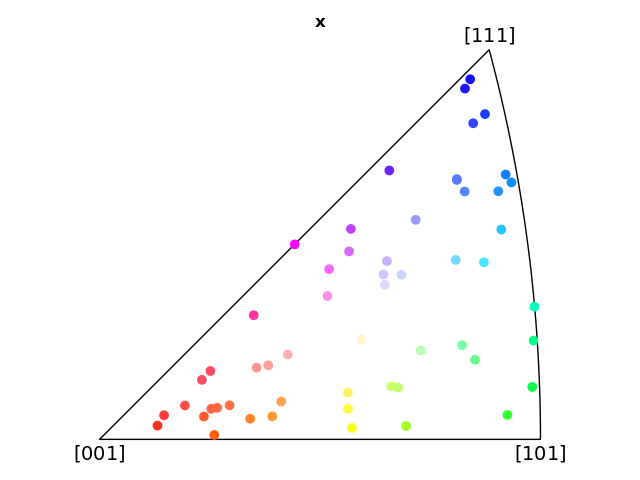

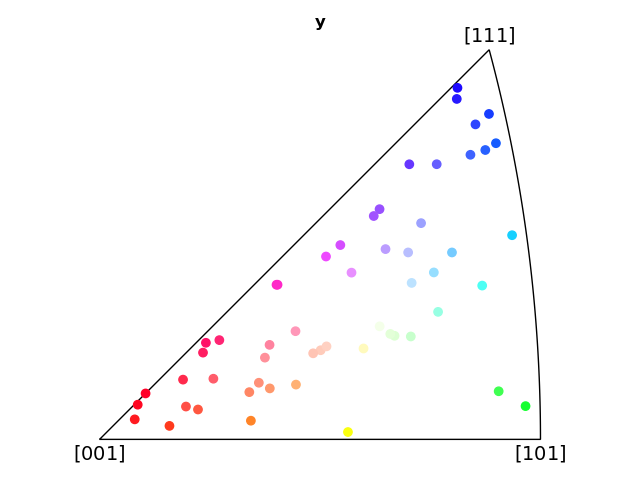

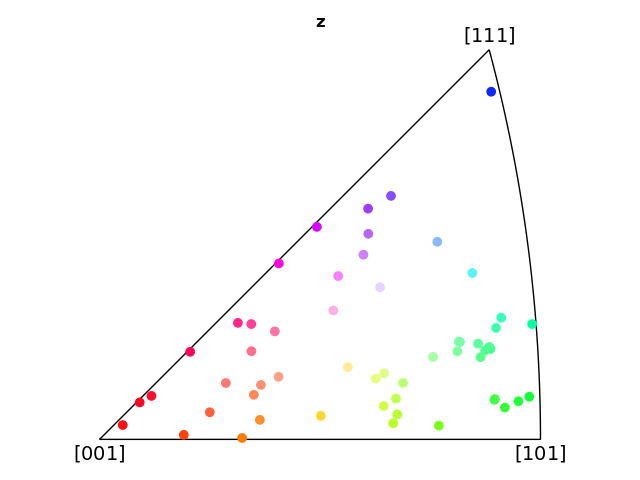

In [17]:
utils.plot_all_ipfs(grains)

# Grain refinement

In [18]:
tmp_ubi_path = 'grains.ubi'
tmp_map_path = 'grains.map'
new_flt_path = 'cf_strong_allrings.flt.new'  # flt file containing assignments from makemap
unindexed_flt_path = 'cf_strong_allrings.flt.unindexed'  # remaining unassigned peaks from makemap
ImageD11.grain.write_grain_file(tmp_ubi_path, grains)

In [19]:
# now we write a classic parameter file for makemap.py
oldparfile = phase_str + '.par'
ds.phases.to_old_pars_file(oldparfile, phase_str)

In [20]:
# now run makemap in a loop
omega_slop = ds.ostep/2
for inc, makemap_tol in enumerate(makemap_hkl_tol_seq):
    print(f"Running makemap {inc+1}/{len(makemap_hkl_tol_seq)}")
    if inc == 0:  # ubi into map
        makemap_output = !makemap.py -p {oldparfile} -u {tmp_ubi_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s {symmetry} -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort
    else:  # map into map
        makemap_output = !makemap.py -p {oldparfile} -u {tmp_map_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s {symmetry} -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort

Running makemap 1/3


Running makemap 2/3


Running makemap 3/3


Using 0.12500652156180614 degree slop
resetting labels


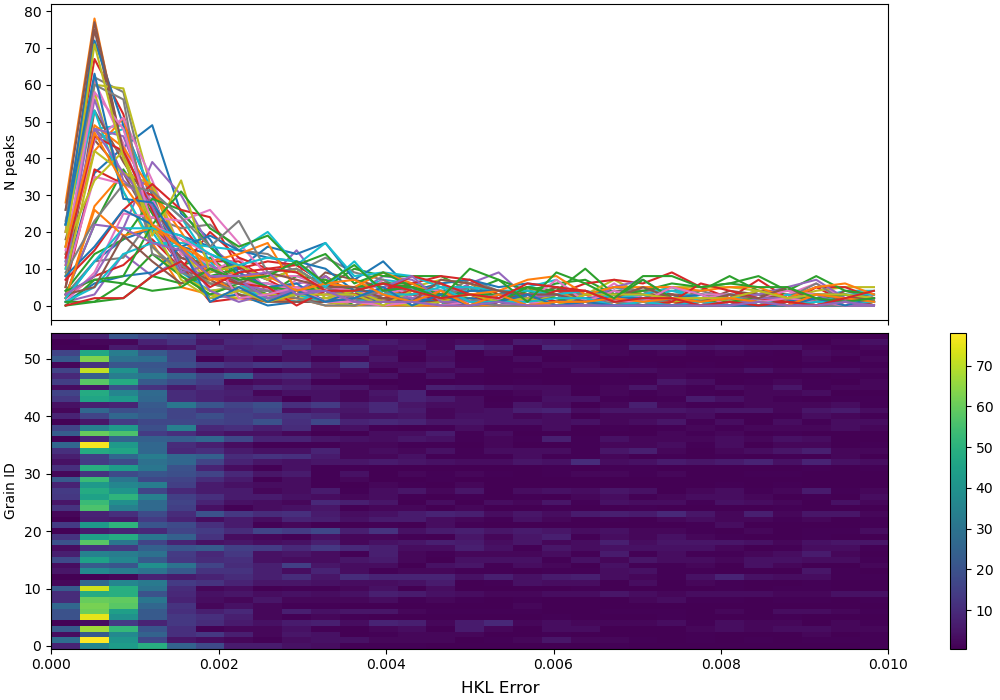

In [21]:
utils.plot_grain_histograms(new_flt_path, tmp_map_path, oldparfile, omega_slop, tol=makemap_hkl_tol_seq[-1])

In [22]:
# re-import our refined grains from the makemap procedure
grains2 = ImageD11.grain.read_grain_file(tmp_map_path)
grains2 = [grain for grain in grains2 if "no peaks" not in grain.intensity_info]
for g in grains2:
    g.ref_unitcell = ucell
utils.get_rgbs_for_grains(grains2)

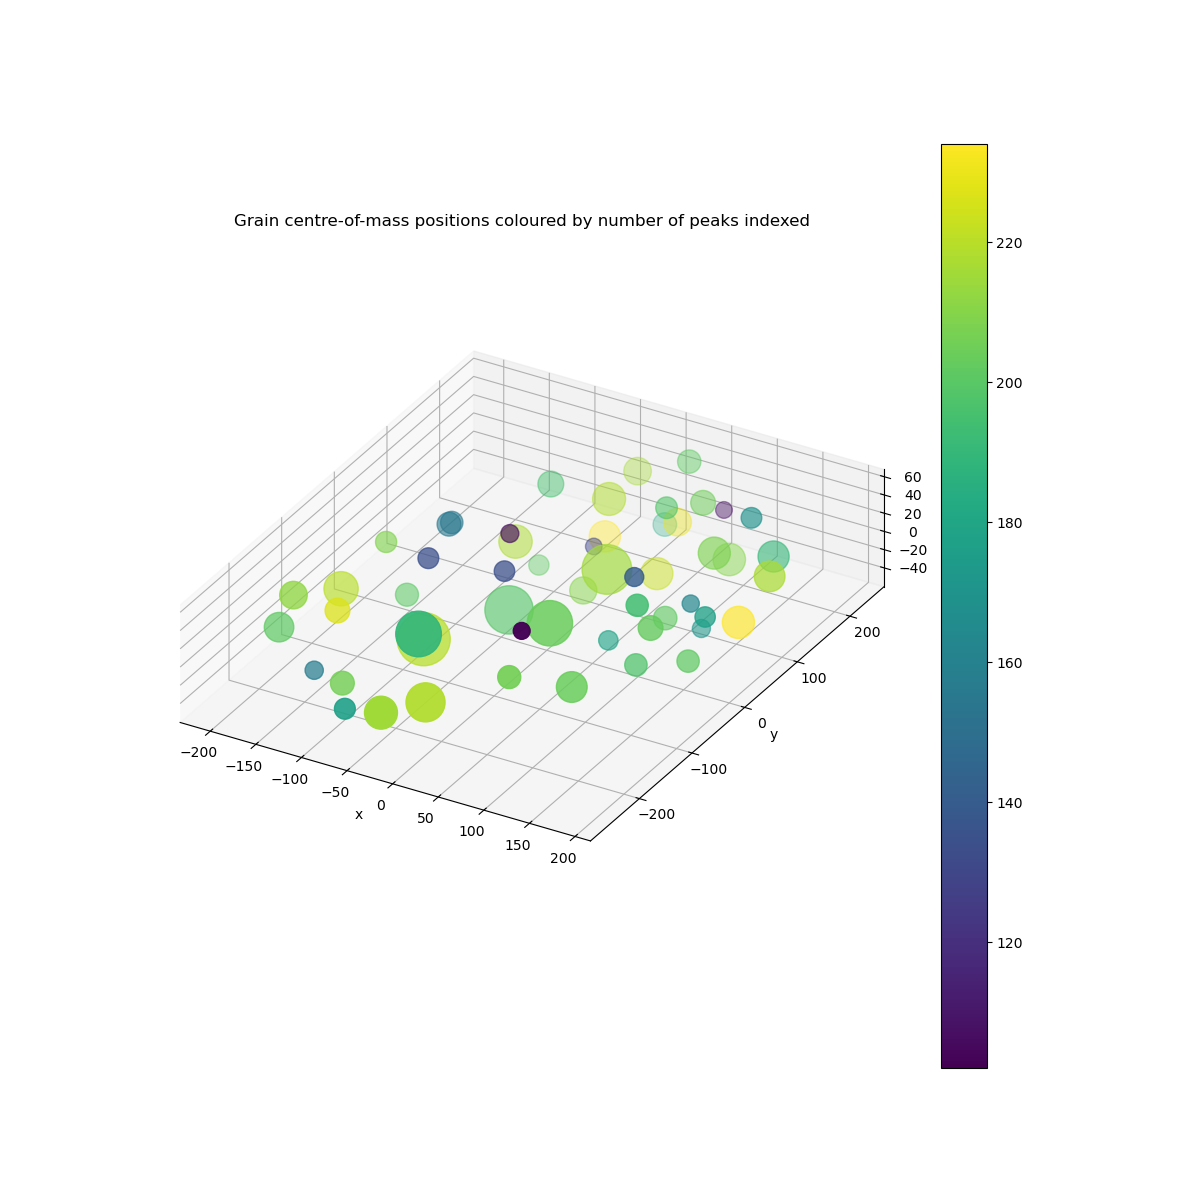

In [23]:
utils.plot_grain_positions(grains2, colour='npks', centre_plot=False, size_scaling=0.5)

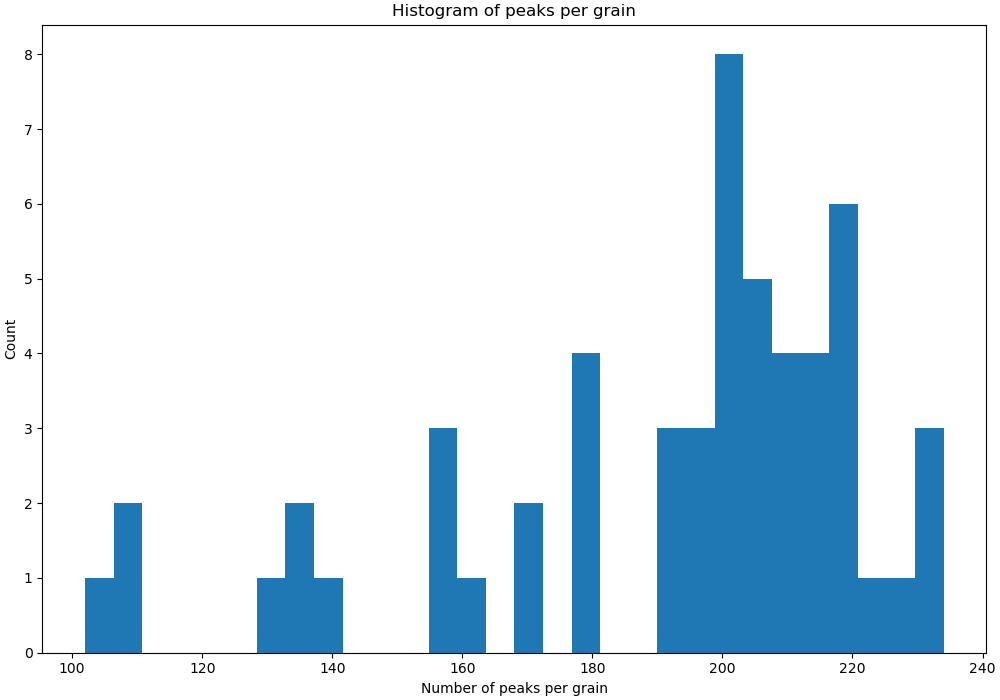

In [24]:
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
ax.hist([float(grain.npks) for grain in grains2], bins=30)
ax.set(xlabel='Number of peaks per grain', ylabel='Count', title='Histogram of peaks per grain')
plt.show()

In [25]:
# filter out grains with fewer than absolute_minpks peaks
# most grains should have a high number of peaks
# choose absolute_minpks such that the low-peak grains are removed
grains_filtered = [grain for grain in grains2 if float(grain.npks) > absolute_minpks]

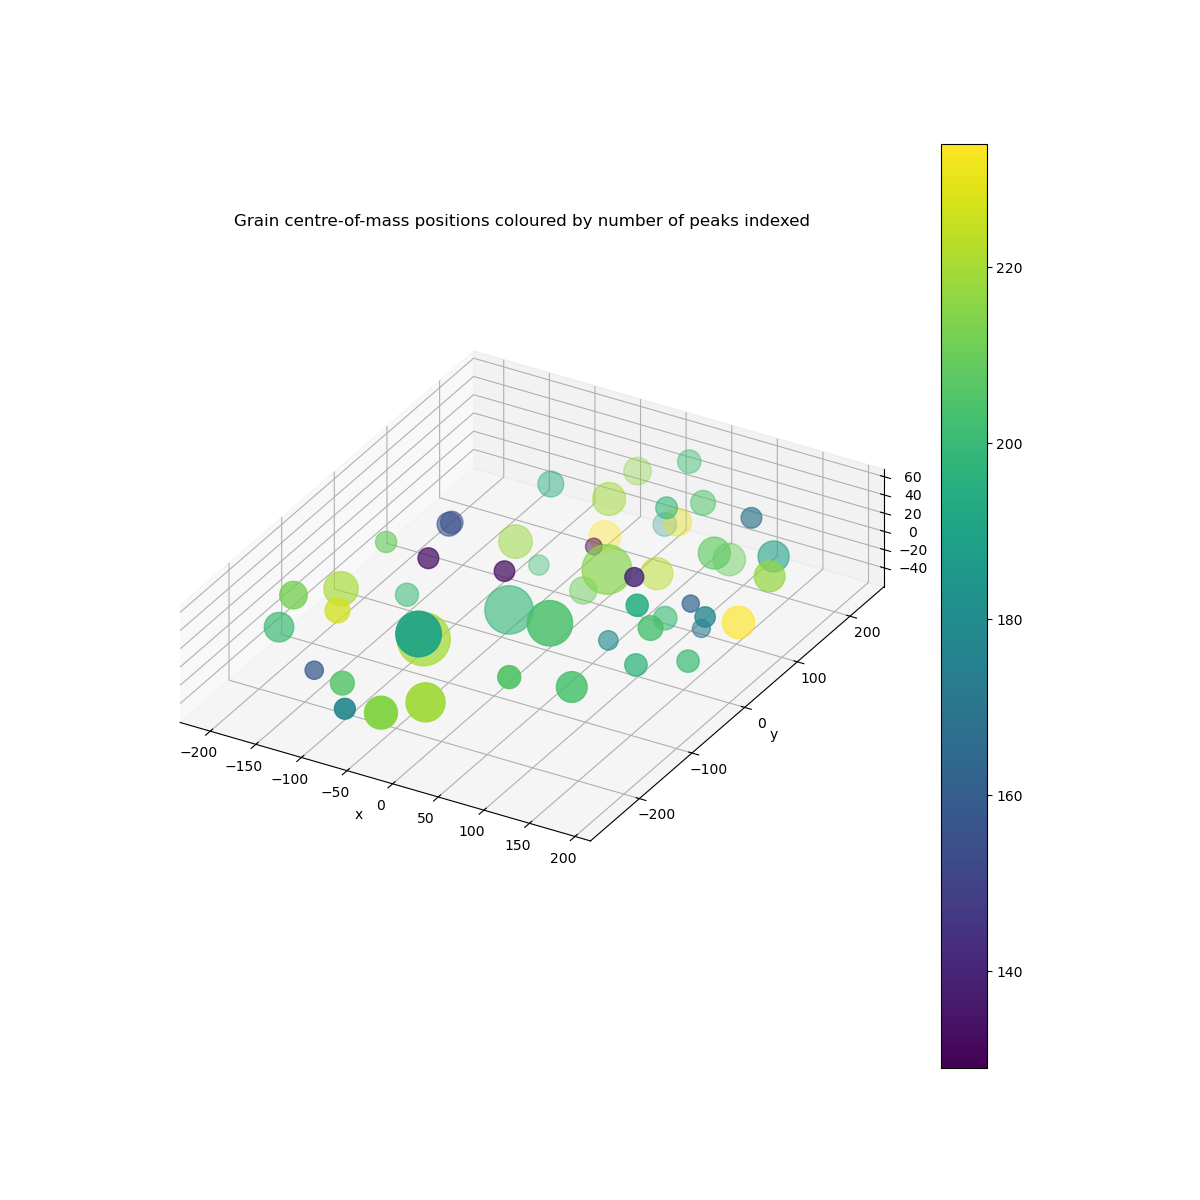

In [26]:
utils.plot_grain_positions(grains_filtered, colour='npks', centre_plot=False, size_scaling=0.5)

In [27]:
# we now have our trustworthy grains
# we should run makemap again to regenerate our peak <-> grain assigments

map_path = 'grains_filtered.map'
final_unindexed_flt_path = 'cf_3d.flt.unindexed'
final_new_flt_path = 'cf_3d.flt.new'

# write filtered grains to disk
ImageD11.grain.write_grain_file(map_path, grains_filtered)

# run makemap on filtered grains with all 3D peaks
makemap_output = !makemap.py -p {oldparfile} -u {map_path} -U {map_path} -f {cf_3d_path} -F {final_unindexed_flt_path} -s {symmetry} -t {makemap_hkl_tol_seq[-1]} --omega_slop={omega_slop} --no_sort

# import makemap output columnfile with peak assignments
cf_3d = ImageD11.columnfile.columnfile(final_new_flt_path)

# write 3D columnfile to disk
ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile, name='peaks')

# re-import filtered grains with new peak statistics
grains_filtered = ImageD11.grain.read_grain_file(map_path)
for g in grains_filtered:
    g.ref_unitcell = ucell
    
utils.get_rgbs_for_grains(grains_filtered)

Using 0.12500652156180614 degree slop


resetting labels


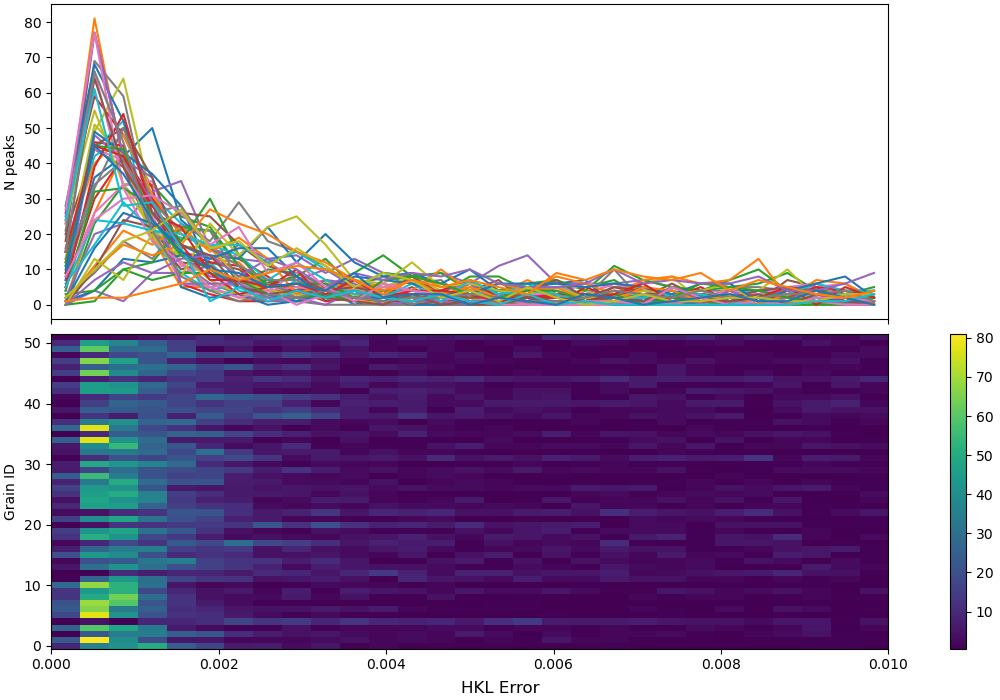

In [28]:
utils.plot_grain_histograms(final_new_flt_path, map_path, oldparfile, omega_slop, tol=makemap_hkl_tol_seq[-1])

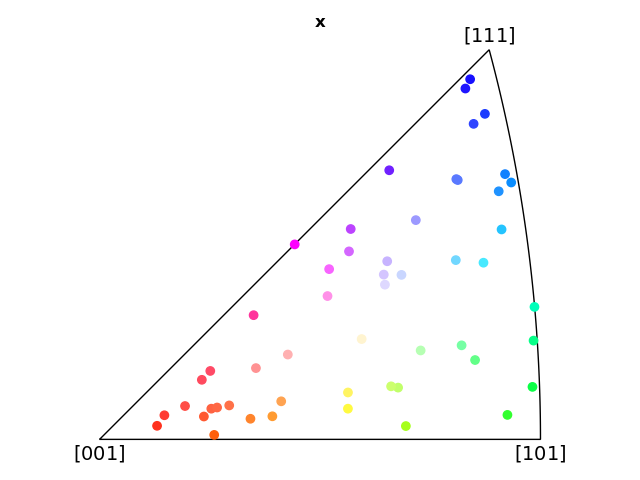

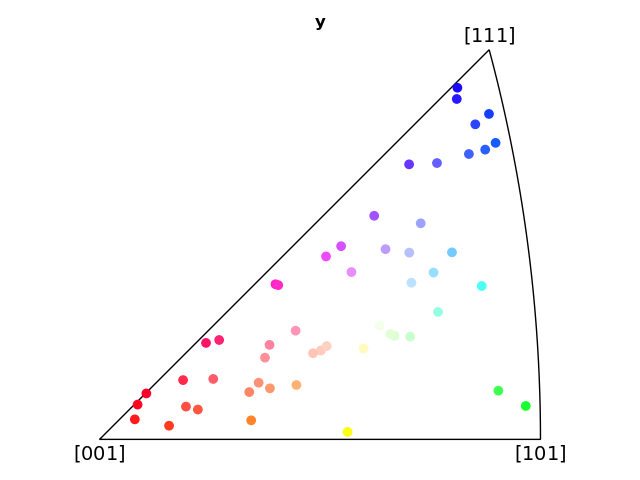

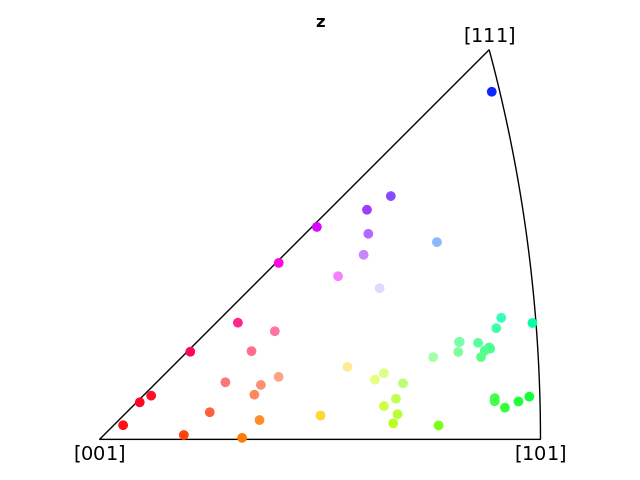

In [29]:
utils.plot_all_ipfs(grains_filtered)

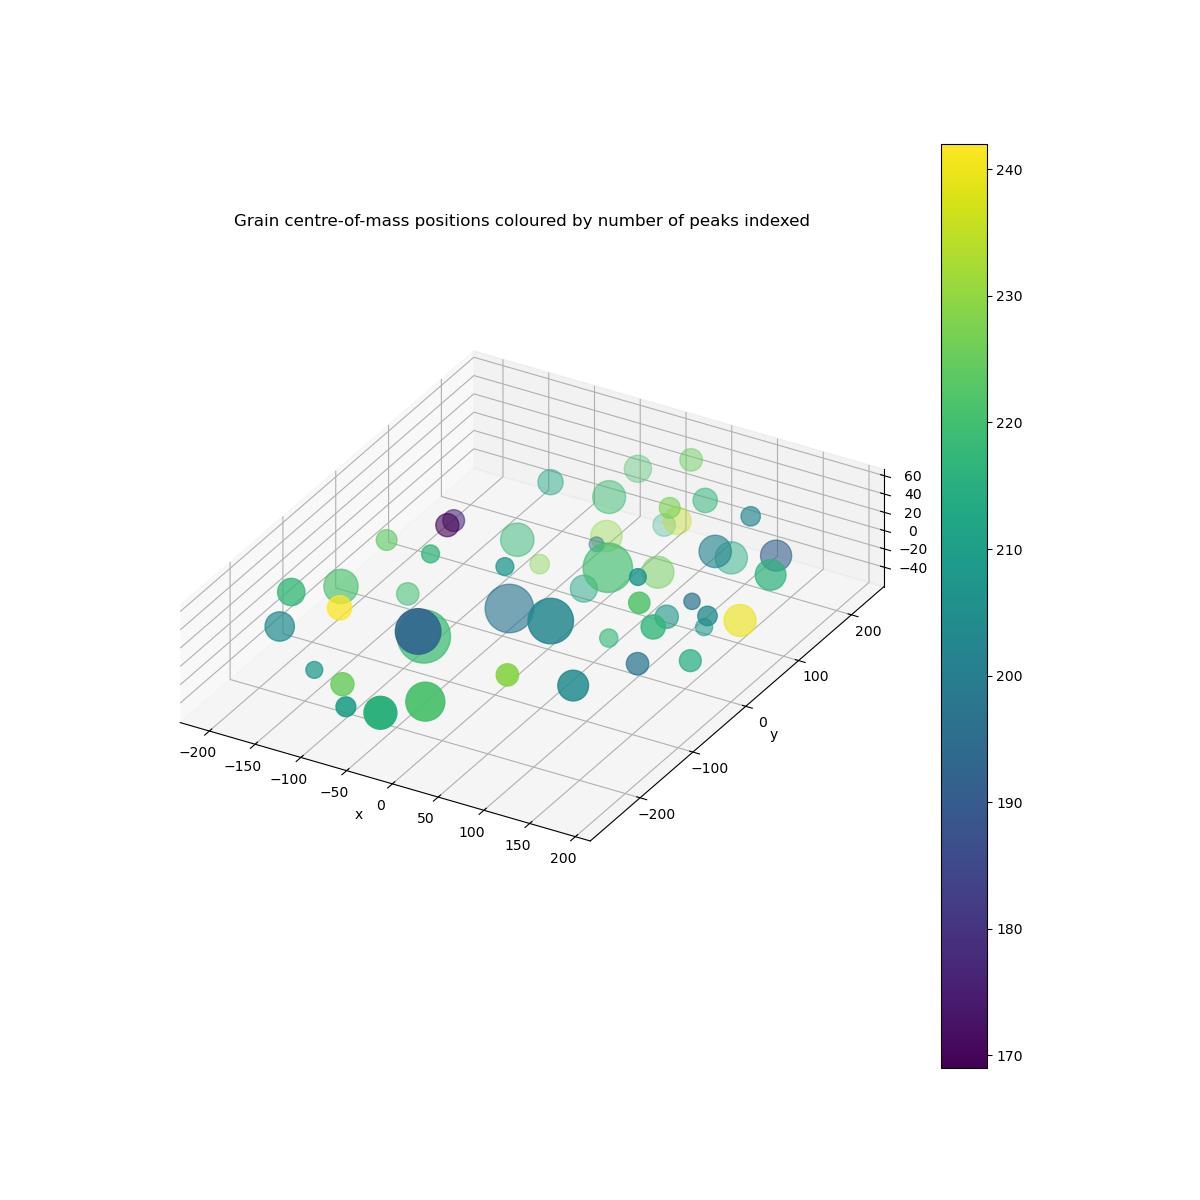

In [30]:
utils.plot_grain_positions(grains_filtered, colour='npks', centre_plot=False, size_scaling=0.5)

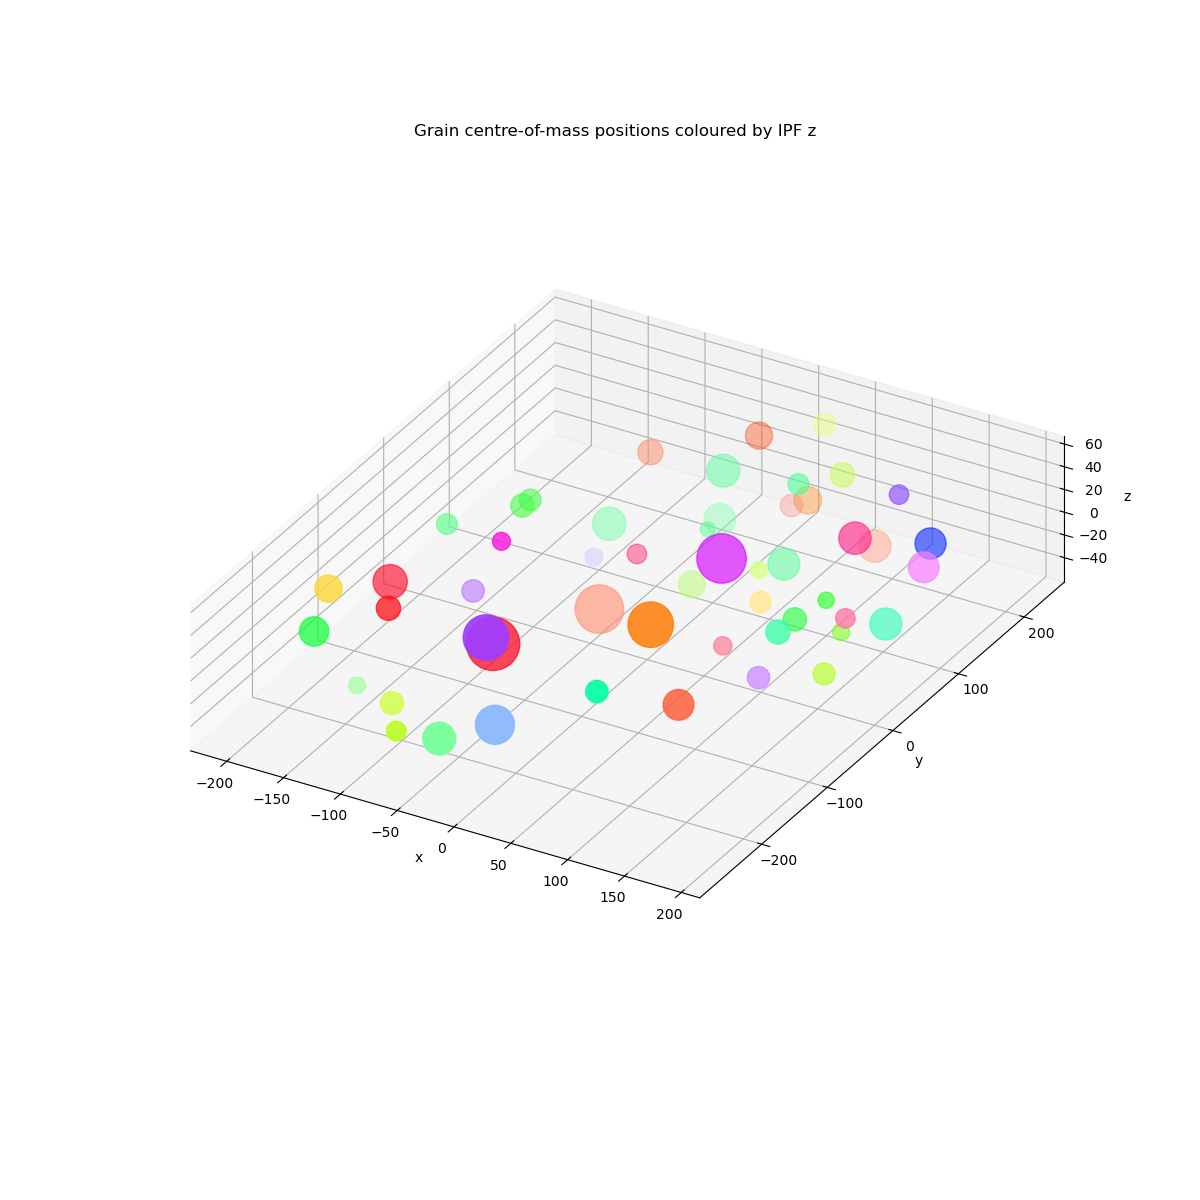

In [31]:
utils.plot_grain_positions(grains_filtered, colour='z', centre_plot=False, size_scaling=0.5)

Median unit cell: [ 2.86914777  2.86976153  2.87050396 89.99079993 90.00111804 90.01090551]


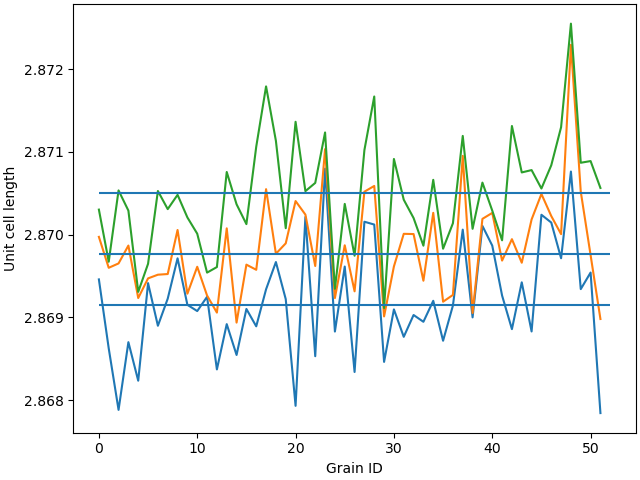

In [32]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains_filtered])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel="Grain ID", ylabel="Unit cell length")
plt.show()

# Export data

In [33]:
ds.save_grains_to_disk(grains_filtered, phase_name=phase_str)

In [34]:
ds.save()

# Deleting temporary files

In [35]:
for path in [
    cf_3d_path,
    cf_strong_path,
    cf_strong_allrings_path,
    tmp_ubi_path,
    tmp_map_path,
    new_flt_path,
    unindexed_flt_path,
    map_path,
    final_unindexed_flt_path,
    final_new_flt_path,
]:
    if os.path.exists(path):
        os.remove(path)